## Import libraries

In [1]:
# Import required libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## Load data

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv')
origin = pd.read_csv('/kaggle/input/horse-survival-dataset/horse.csv')
# Combine both original and training data
train = pd.concat([train, origin], ignore_index=True)

## Feature Engineering

The feature transforms below have been very carefully done by doing extensive EDA and feature engineering. The full feature engineering and EDA can be found in [this notebook](https://www.kaggle.com/code/nikhil1e9/s3-e22-full-feature-analysis). After successive repetitions and model training with different feature transformations these turned out to be the best.

In [3]:
# Feature transformations
def clean_and_transform(df):
    # change 3 to more_3_sec
    df['capillary_refill_time'].replace({'3': 'more_3_sec'}, inplace=True)
    # convert slight and moderate to mild pain category
    df['pain'].replace({'slight': 'mild_pain'}, inplace=True)
    df['pain'].replace({'moderate': 'mild_pain'}, inplace=True)
    # clean below 3 columns
    df['peristalsis'].replace({'distend_small': np.nan}, inplace=True)
    df['nasogastric_reflux'].replace({'slight': np.nan}, inplace=True)
    df['rectal_exam_feces'].replace({'serosanguious': np.nan}, inplace=True)
    
#     df['rectal_temp'] = abs(df['rectal_temp'] - 37.8)
#     df['pulse_resp'] = df['pulse']*df['respiratory_rate']
#     df['pulse'] = abs(df['pulse'] - 60)
#     df['protein'] = df['total_protein']/df['abdomo_protein']
#     df['total_protein_cat'] = df['total_protein'] > 40
    df['lesion_1'] = df['lesion_1'].astype('str')
    df['lesion1'] = df['lesion_1'].apply(lambda x: x+'0'*(4-len(x)) if len(x) <= 4 else x)
    df['lesion_site'] = df['lesion1'].apply(lambda x: x[:2] if len(x) == 5 and x[0] == '1' else x[0])
    df['lesion_type'] = df['lesion1'].apply(lambda x: x[2] if len(x) == 5 and x[0] == '1' else x[1])
    df['lesion_subtype'] = df['lesion1'].apply(lambda x: x[3] if len(x) == 5 and x[0] == '1' else x[2])
    df['lesion_code'] = df['lesion1'].apply(lambda x: x[-2:] if len(x) == 5 and x[0] != '1' else x[-1])
    df.lesion_type.replace({'7': '0'}, inplace=True)
    df = df.drop(['id', 'lesion1', 'lesion_1', 'lesion_2', 'lesion_3'], axis=1)
    return df

train_df = clean_and_transform(train)
test_df = clean_and_transform(test)

## Impute missing values

In [4]:
# Replace categorical missing values with mode
def impute_cat(df):
    for col in df.select_dtypes('object').columns:
        mode = df[col].mode().values[0]
        df[col] = df[col].fillna(mode)
    return df
# Impute numerical missing values with KNN imputer
def impute_numeric(df):
    imputer = KNNImputer()
    numeric_cols = df.select_dtypes('number').columns
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    return df

train_df = impute_cat(train_df)
train_df = impute_numeric(train_df)
test_df = impute_cat(test_df)

In [5]:
# Sanity check for missing values
train_df.isnull().sum()

surgery                  0
age                      0
hospital_number          0
rectal_temp              0
pulse                    0
respiratory_rate         0
temp_of_extremities      0
peripheral_pulse         0
mucous_membrane          0
capillary_refill_time    0
pain                     0
peristalsis              0
abdominal_distention     0
nasogastric_tube         0
nasogastric_reflux       0
nasogastric_reflux_ph    0
rectal_exam_feces        0
abdomen                  0
packed_cell_volume       0
total_protein            0
abdomo_appearance        0
abdomo_protein           0
surgical_lesion          0
cp_data                  0
outcome                  0
lesion_site              0
lesion_type              0
lesion_subtype           0
lesion_code              0
dtype: int64

## Modeling and Feature selection

In [6]:
X = pd.get_dummies(train_df.drop('outcome', axis=1))
y = train['outcome'].map(({'died': 0, 'lived': 1, 'euthanized': 2}))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=24)

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_preds = xgb.predict(X_test)
microF = f1_score(y_test, y_preds, average='micro')
print("Validation accuracy:", accuracy_score(y_test, y_preds))
print("Micro-averaged F1-Score:", microF)

Validation accuracy: 0.7328990228013029
Micro-averaged F1-Score: 0.7328990228013029


### Feature importances

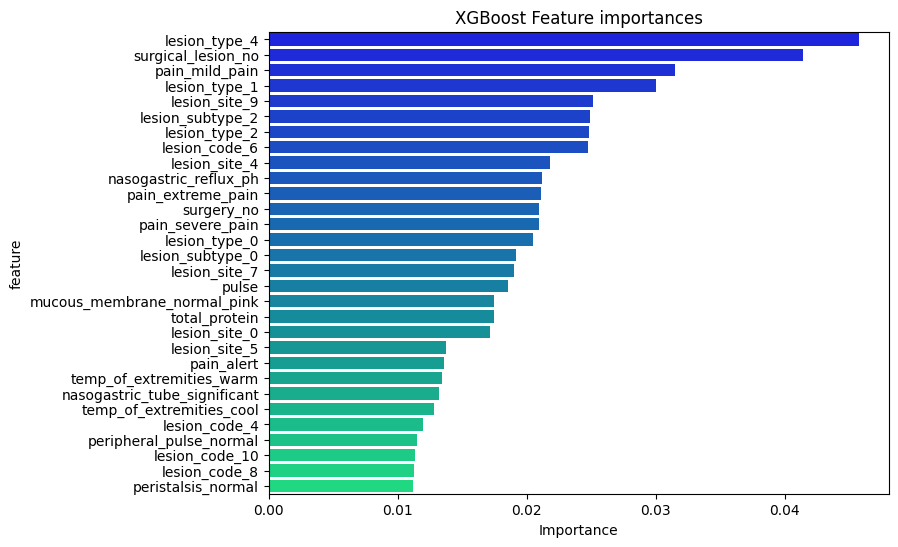

In [7]:
# Plot feature importances
feature_imp = pd.DataFrame({'feature': X_train.columns, 'Importance': xgb.feature_importances_}) 
feature_imp = feature_imp.sort_values('Importance', ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(data=feature_imp[:30], x='Importance', y='feature', palette='winter')
plt.title("XGBoost Feature importances")
plt.show()

In [8]:
feature_imp.shape

(95, 2)

In [9]:
# Evaluating models on different thresholds
def model_score():
    thresholds = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
    models = {'xgb': XGBClassifier(random_state=24), 
               'lgbm': LGBMClassifier(random_state=24), 
               'cat': CatBoostClassifier(verbose=False, random_state=24)}
    for thresh in thresholds:
        imp_cols = feature_imp[feature_imp['Importance'] > thresh]['feature'].values.tolist()
        print(f"----------Model scores with {thresh} feature threshold----------")
        Xf = X[imp_cols]
    #     y = train['outcome'].map(({'died': 0,'lived': 1,'euthanized': 2}))
        X_train, X_test, y_train, y_test = train_test_split(Xf, y, test_size=0.2, stratify=y, random_state=24)
        Fscores = []
        for k, mod in models.items():
            mod.fit(X_train, y_train)
            y_preds = mod.predict(X_test)
            microF = f1_score(y_test, y_preds, average='micro')
#             print(f"MODEL: {k}")
#             print("Validation accuracy:", accuracy_score(y_test, y_preds))
#             print("Micro-averaged F1-Score:", microF)
            Fscores.append(microF)
#             print("*"*50)
        print(np.mean(Fscores))
model_score()

----------Model scores with 0.0 feature threshold----------
0.7480998914223669
----------Model scores with 0.001 feature threshold----------
0.7480998914223669
----------Model scores with 0.002 feature threshold----------
0.747014115092291
----------Model scores with 0.003 feature threshold----------
0.750271444082519
----------Model scores with 0.004 feature threshold----------
0.747014115092291
----------Model scores with 0.005 feature threshold----------
0.741585233441911
----------Model scores with 0.006 feature threshold----------
0.740499457111835
----------Model scores with 0.007 feature threshold----------
0.749185667752443
----------Model scores with 0.008 feature threshold----------
0.744842562432139
----------Model scores with 0.009 feature threshold----------
0.740499457111835
----------Model scores with 0.01 feature threshold----------
0.7198697068403909


In [10]:
features = feature_imp[feature_imp['Importance'] > 0.0]['feature'].values.tolist()
print(f"Number of important features: {len(features)}")
print(f"Number of uninformative features: {len(feature_imp)-len(features)}")

Number of important features: 85
Number of uninformative features: 10


### Modeling with selected features

In [11]:
X = pd.get_dummies(train_df.drop('outcome', axis=1))
y = train['outcome'].map(({'died': 0,'lived': 1,'euthanized': 2}))
# Stratified split with 20% validation data in each split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
f1, f2 = 0.0, 0.0

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X.iloc[train_idx][features], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx][features], y.iloc[val_idx]
    
    model_xgb = XGBClassifier()
    model_lgbm = LGBMClassifier()
    
    model_xgb.fit(X_train, y_train, verbose=False)
    model_lgbm.fit(X_train, y_train, verbose=False)
    
    val_preds_xgb = model_xgb.predict(X_valid)
    val_preds_lgbm = model_lgbm.predict(X_valid)
    
    F_score_xgb = f1_score(y_valid, val_preds_xgb, average='micro')
    F_score_lgbm = f1_score(y_valid, val_preds_lgbm, average='micro')
    f1 += F_score_xgb
    f2 += F_score_lgbm
    
    print(f"------FOLD {fold+1}------")
    print("XGBoost score:", F_score_xgb)
    print("LGBM score:", F_score_lgbm)
    
print("\nMean F-score for XGBoost")
print(f1/5)
print("Mean F-score for LGBM")
print(f2/5)
print("Combined mean score:", (f1+f2)/10)

------FOLD 1------
XGBoost score: 0.7361563517915309
LGBM score: 0.739413680781759
------FOLD 2------
XGBoost score: 0.7882736156351792
LGBM score: 0.771986970684039
------FOLD 3------
XGBoost score: 0.7361563517915309
LGBM score: 0.7328990228013029
------FOLD 4------
XGBoost score: 0.7068403908794788
LGBM score: 0.7198697068403909
------FOLD 5------
XGBoost score: 0.7483660130718954
LGBM score: 0.738562091503268

Mean F-score for XGBoost
0.7431585446339231
Mean F-score for LGBM
0.7405462945221519
Combined mean score: 0.7418524195780375


## Final predictions

In [12]:
final_feat = feature_imp[feature_imp['Importance'] > 0.0]['feature'].values.tolist()
X_final = pd.get_dummies(test_df)[final_feat]
xgb = XGBClassifier()
xgb.fit(X[final_feat], y)
preds = xgb.predict(X_final) 

## Submission

In [13]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e22/sample_submission1.csv')
sub['outcome'] = preds
sub['outcome'] = sub['outcome'].map({0: 'died', 1: 'lived', 2: 'euthanized'})
sub.to_csv("submission.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/playground-series-s3e22/sample_submission1.csv'